In [1]:
from TMP117 import TMP117
from MPU6050 import MPU6050
from TP import TP
from CAP11NA import CAP11NA
from BM1422 import BM1422
from SM141K import SM141K 
from plotAll import generateActiveList, plotTogether

#Duration controls how long all of the sensors are active for, and time_step controls
#the distance between data values. 
duration = 1000
time_step = 0.01

[['0b1', '0b11111111', '0b0'], ['0b0', '0b1001011', '0b111'], ['0b0', '0b1011010', '0b100']]


> # Model Description
* This model is to be used by teams for the GLEE 2022 workshop
* The teams will change parameters that will affect the power and data for each sensor
* The output of this model will be a plot of each sensor's power/data output vs time as well as a plot with all the sensor outputs in a single plot
* A solar model is also included for reference
* All the code for this model is in the .py files and accessed in this file through the import statements at the top of this file
***  


> # How to use Jimmy
Welcome to Jimmy, an interactive model of the individual sensors on a LunaSat. Jimmy's main goal is to measure the power and data rates of different sensor mode configurations.

Sensors are defined as a class object each with customizable parameters. Changing these parameters can change the way your LunaSat behaves, such as taking more measurements and collecting more data, or going into low power mode and saving resources.

A schedule of modes can be made easily using dictionaries and the generateActiveList function. This is best described in an example.
Lets say I want the accelerometer to repeat a cycle: low power mode for 50 seconds, gyroscope + accelerometer mode for 40 seconds, then accelerometer only mode for 20 seconds. Heres what the code would look like:
```py
modedict = {"low_power_wakeup_1.25":50, "gyroscope_accelerometer":40, "accelerometer_only": 20}

active_times = generateActiveList(total_time=duration, modedict=modedict)

time_acc, power_acc, data_acc = accelerometer.runSim(active_times)
```

># `Temperature Sensor Configurations`
### General Description:
* "The TMP117 is a high-precision digital temperature sensor"
* It provides a 16-bit temperature result with accuracy of up to $\pm 0.1 ^{\circ}C$ and resolution of $\pm 0.0078 ^{\circ}C$. 
* TMP117 has a programmable EEPROM (electrically erasable programmable read-only memory) and has 48-bits of memory available for general use 
* The selectable averaging option allows users to configure the device to report the average of multiple temp. conversions. 

### Modes info:
> $\text{ One-Shot Mode}$ 
* One-shot mode: After the device completes a (temperature conversion) one-shot conversion, the device goes to the low-power shutdown mode. For OS mode, the conv cycle time is the active time so the possible conv cycle times are only 0.0155, 0.125, 0.5, 1 since there is no standby.   
  
- PARAMS:  
    * Possible conversion cycle times (only first row of Table): 0.0155, 0.125, 0.5, 1 
    * Possible averaging inputs: 0, 8, 32, 64

> $\text{Continuous Conversion Mode}$
* Continuous conversion mode: The device continuously performs temperature conversions in this mode, as shown in Table, and updates the temperature result register at the end of every active conversion. The total conversion cycle includes the active conversion time and standby time.  
  
* PARAMS:  
    * Possible conversion cycle times (see Table below): 0.0155, 0.125, 0.25, 0.5, 1, 4, 8, 16  
    * Possible averaging inputs: 0, 8, 32, 64
   
<center> <img src='convTimes.png' width="700" height="200">  

*Columns represent averaging: 0, 8, 32, 64 (left to right)*  
*Rows represent active conversion time: 0.0155, 0.125, 0.25, 0.5, 1, 4, 8, 16 (from top to bottom)*    
*The numbers inside the table itself represent the total conv cycle time* 
</center> 
    
For additional information:  
https://www.ti.com/lit/ds/symlink/tmp117.pdf?ts=1656974490603&ref_url=https%253A%252F%252Fwww.ti.com%252Ftechnologies%252Finternet-of-things%252Foverview.html 

*** 

#### TO-DO: Change parameters for TMP117 below

In [2]:
'''
    Explanations of Params:
        modedict is a dictionary with parameters in the format ----> "Mode_NumAverages_ConvCycleTime": duration

        * duration is in seconds and indicates how long you want this mode with its params to be turned on

        * Mode: 
            CC is continuous conversion mode
            OS is one-shot mode
            OFF just means the sensor is turned off

        * NumAverages: 0, 8, 32, 64
            
        * ConvCycleTime: 
            for OS mode:  0.0155, 0.125, 0.25, 0.5, 1, 4, 8, 16  
            for CC mode:  0.0155, 0.125, 0.5, 1 

    A default mode dict has been created for you outside the comments below.
    
'''

defaultOption = {"CC_32_16":15, "OS_64_1":15, "OS_32_0.0155":40, "OFF_0_0": 10} 

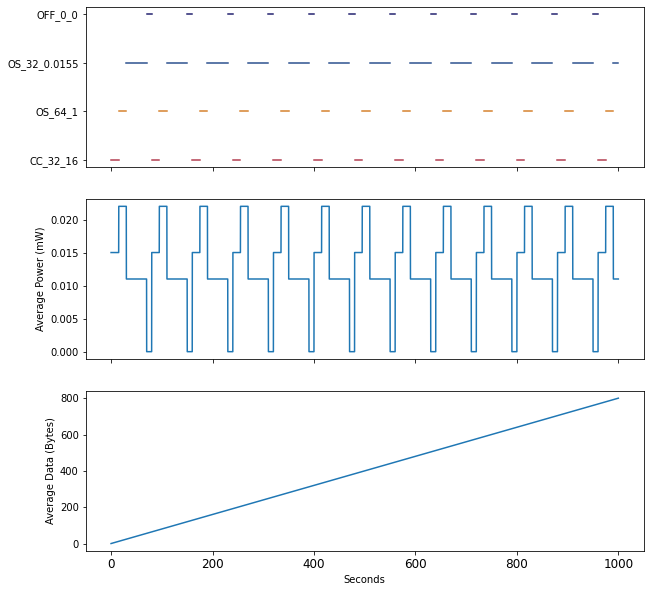

In [3]:
active_list = generateActiveList(duration, defaultOption)
tmp2 = TMP117(time_step, duration, active_list, loop_rate = 20)
power_tmp, data_tmp, time_tmp= tmp2.runSim(plot=True);

*** 

# `Accelerometer Configurations`

MPU6050 description:
- Gyroscope operating current: 3.6 mA
- Accelerometer operating current: 500 µA
    * Low power accelerometer mode current: 10µA at 1.25Hz, 20µA at 5Hz, 60µA at 20Hz, 110µA at
40Hz
- Everything enabled: 3.9 mA
- 16-bit registers for storing accelerometer/ gyroscope data, one per axis for each.
- 1024 byte FIFO buffer allowing reading/ writing data from registers.
- Temperature range is -40 to 85 °C

Modes:
- Low power wakeup: mode specific to the accelerometer, updates axis registers at the rate specified in the mode: 1.25 Hz, 5 Hz, 20 Hz and 40 Hz. 
    - Names of different low power modes: low_power_wakeup_1.25, low_power_wakeup_5, low_power_wakeup_20, low_power_wakeup_40
- Can specify which components are active at any given time. 
    - Names of different modes: gyroscope_accelerometer_DMP, gyroscope_accelerometer, gyroscope_DMP, gyroscope_only, accelerometer_only.
    * Power of each mode goes from greatest to least in the list above.

Parameters:
- **digital low pass:** configures the digital low pass filter settings on the sensor. Setting digital_low_pass to 1 changes the output rate, 8kHz when 0 and 1kHz when 1.
- **sample rate divisor:** is a parameter to lower the sampling rate of the sensor. This value ranges from 0 to 255, and is used in the equation below.
    * Sample Rate = Gyroscope Output Rate / (1 + SMPLRT_DIV)
    * Note: gyroscope output rate changes if the digital low pass filter is on or not, 1kHz when on and 8kHz when off.
- **loop rate:** is a hypothetical bottleneck to the measuring rate of the sensor; it represents the loop rate of the LunaSat code.

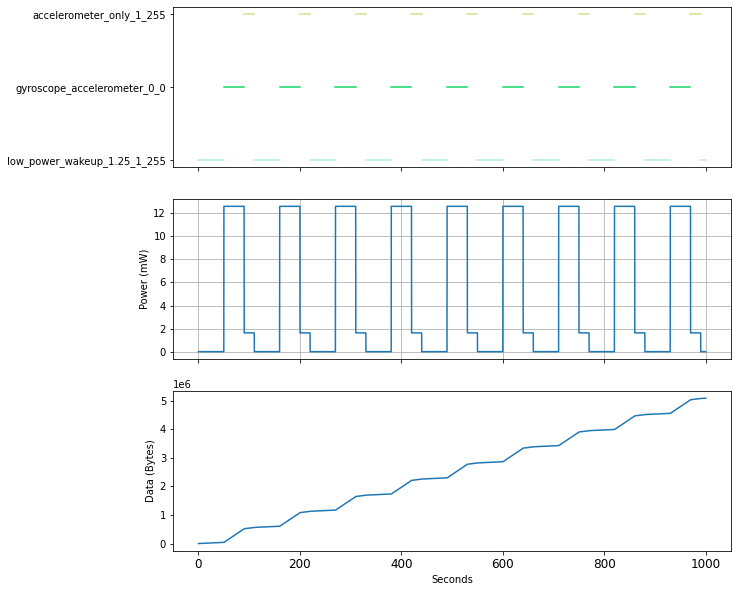

In [4]:
accelerometer = MPU6050(time_step=time_step, duration=duration, 
loop_rate=20)

modedict = {"low_power_wakeup_1.25_1_255":50, "gyroscope_accelerometer_0_0":40, "accelerometer_only_1_255": 20, "low_power_wakeup_1.25_1_255":50,}
active_times = generateActiveList(total_time=duration, modedict=modedict)
time_acc, power_acc, data_acc = accelerometer.runSim(active_times)

***

# `Thermopile Configurations`

The args we pass in to the function is the time_step and duration. As with the active times, we pass in what mode we want the sensro to run on as well as the times we want it to be active. The two possible modes are "TP_only" and "TP_off"

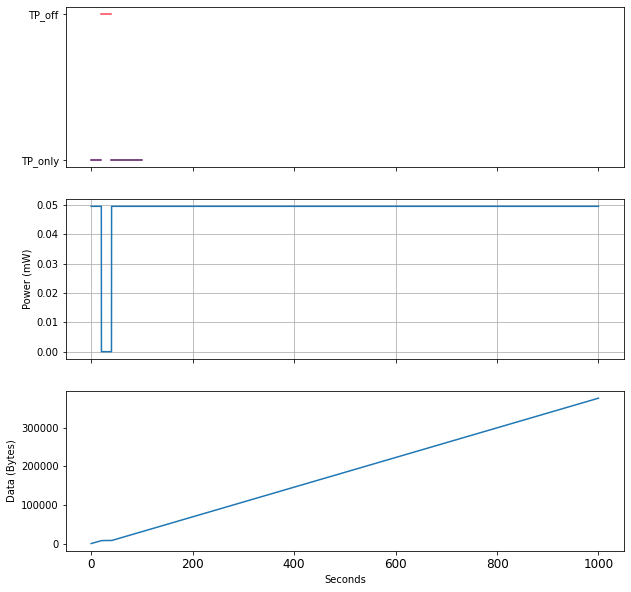

In [5]:
Thermo = TP(time_step, duration, loop_rate=20)
active_times = [(0,20,"TP_only"), (20,40,"TP_off"), (40,100,"TP_only")]
tp_time, tp_power, tp_data = Thermo.runSim(active_times)

***

# `Capacitor Configurations`

CAP11NA description:
- We don't have a ton of info on this one. Citation needed?

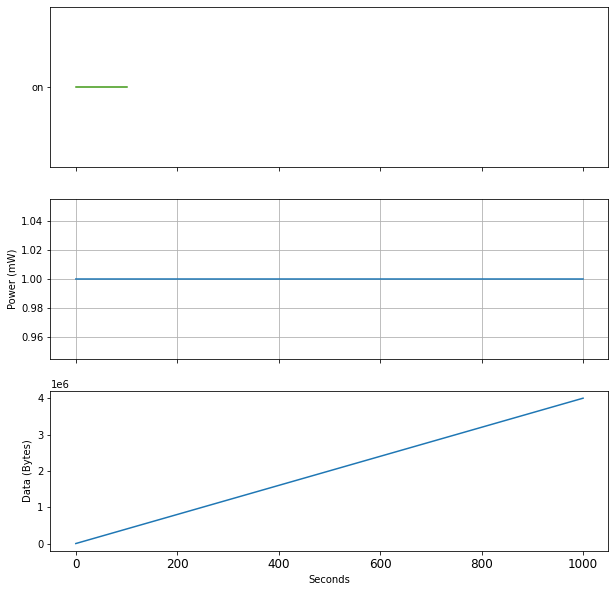

In [6]:
cap = CAP11NA(loop_rate=20, duration=duration, time_step=time_step)
cap_active_times = [(0,100,"on")]
cap_time, cap_power, cap_data = cap.runSim(cap_active_times)

***

# `Magnetometer Configurations`

BM1422 description:
- 0.15 mA operating current at 100SPS.
- Operating temperature -40 to 85 °C
- things?

Modes:
- The sensor supports different output rates for measuring, the options aer 10Hz, 20Hz, 100Hz, and 1kHz. These only change the amount of data collected, not the power. 
- There are continous and single modes, however the documentation for these is not great.


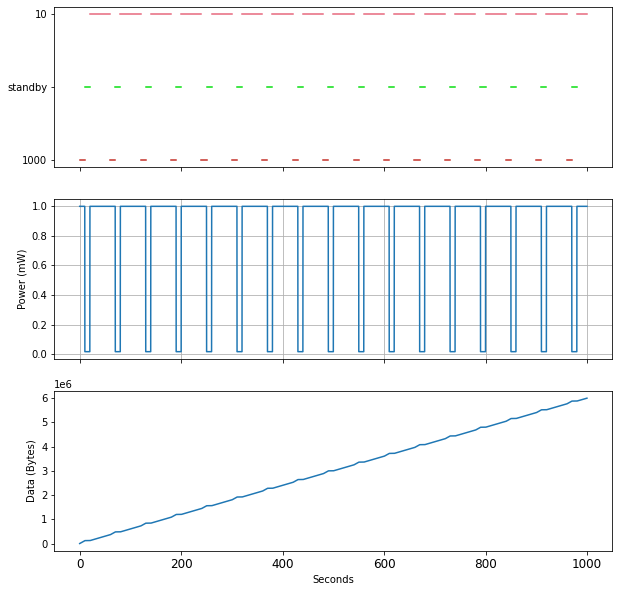

In [7]:
foo = BM1422(loop_rate=20, duration=duration, time_step=time_step)
#for magnetometer, the certain mode is the timing specification, or standby.
modedict = {"1000":10, "standby":10,"10":40}
mag_activetimes = generateActiveList(total_time=duration, modedict=modedict)
mag_time, mag_power, mag_data = foo.runSim(mag_activetimes)

***

# `Solar Panel Model`

In [8]:
#power used by ATMega
chip_pow = 20

# `Solar Panel Model`

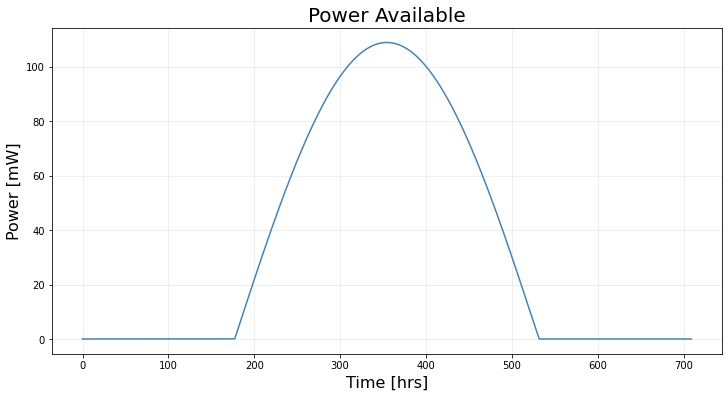

In [9]:
# the solar model plots the power available in a lunar day

solar_panel_model = SM141K(start_time_hrs=0, duration_hrs=709, time_step_seconds=30, latitude=45)
solar_panel_model.plotPowerAvailable()

# `All Together`

In [10]:
total_pow = power_tmp + mag_power + power_acc + cap_power + tp_power + chip_pow
total_data = data_tmp + mag_data + data_acc + cap_data + tp_data

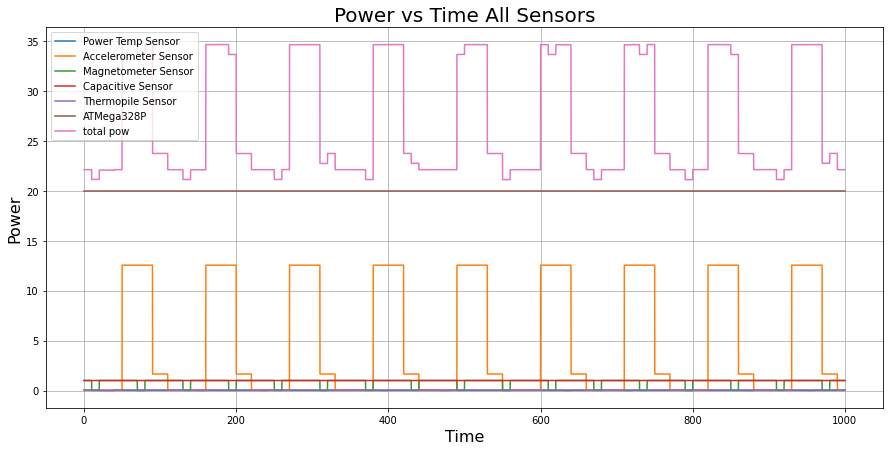

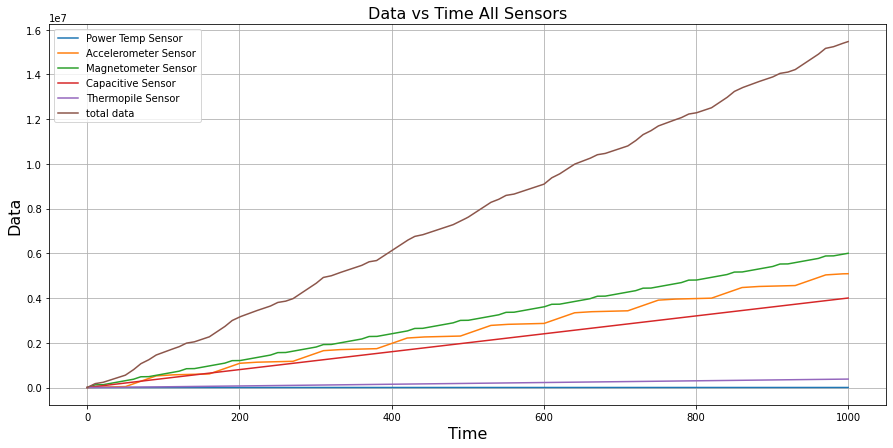

In [11]:
plotTogether(time_tmp, time_acc, tp_time, cap_time, mag_time, tp_power, power_tmp, power_acc, mag_power, cap_power, data_tmp, data_acc, mag_data, cap_data, tp_data, total_pow, total_data, chip_pow)


[213.75, 495.25]

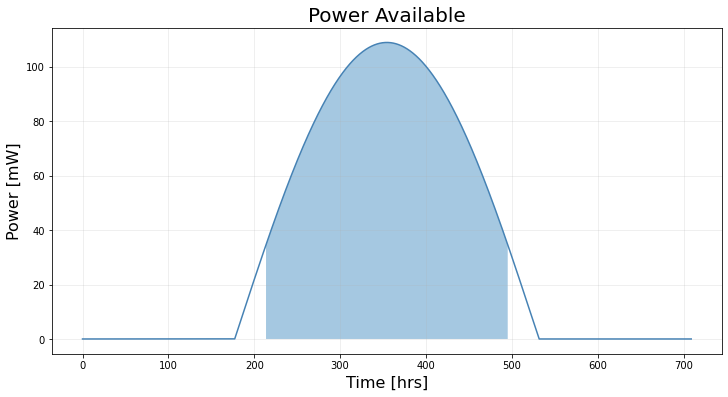

In [12]:
# The model shows the times in the shaded region where the solar panel produces enough power for the LunaSat with the given modes for each sensor

max_power_used = max(total_pow)
solar_panel_model.plotPowerAndTimesPossible(max_power = max_power_used)